# Exploratory Analisys

## Context

As discussed in previous notebooks, we will use a tree-based model to predict the residuals of our harmonic regression. The most common options are Random Forest — which we also used for feature selection — and XGBoost. Both models are appropriate and have distinct advantages and limitations in this context. To determine which model to use, we will compare their predictive performance. Because their internal structures differ, they may perform differently on the same feature set, therefore, we first define the feature set for each model and then evaluate and compare their forecasting accuracy.

**Data Source**
The data used in this notebook was extracted from the notebook *eda-non-linear.ipynb*

- **Data:** 19/08/2025
- **Localização:** ../data/wrangle

## Set up

### Libraries

In [1]:
## Base
import os
import pickle
import numpy as np
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.inspection import permutation_importance
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
import shap

In [2]:
# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[1].as_posix())

from src.ts_utils import *

from config import *

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

## Data

The first step in our comparison is to define the training dataset. We will use 7 years of data, split between training and validation, ensuring that after feature engineering we still retain enough data to properly train and test our models in this stage.

In [4]:
df = pd.read_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_sanitized.parquet'))
df = df.head(7 * 365).set_index('time')
display(df.head())
df.info()

,tavg,prcp,snow,wspd,pres,tamp,wcardinal
time,,,,,,,
2015-09-01,300.6,0.0,0.0,3.8,1015.8,8.4,South
2015-09-02,301.1,0.0,0.0,3.6,1015.0,10.5,Southwest
2015-09-03,301.2,0.0,0.0,4.2,1012.4,10.6,Southwest
2015-09-04,297.9,0.0,0.0,2.9,1015.0,8.5,Southwest
2015-09-05,298.5,0.0,0.0,3.1,1017.6,7.9,South


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2555 entries, 2015-09-01 to 2022-08-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   tavg       2555 non-null   float64 
 1   prcp       2555 non-null   float64 
 2   snow       2555 non-null   float64 
 3   wspd       2555 non-null   float64 
 4   pres       2555 non-null   float64 
 5   tamp       2555 non-null   float64 
 6   wcardinal  2555 non-null   category
dtypes: category(1), float64(6)
memory usage: 142.6 KB


In [5]:
feature_imp = pd.read_parquet(DATA_PATH_WRANGLE / "feature_importance.parquet")
display(feature_imp.head())
feature_imp.info()

,feature,importance
0,snow_387,0.020859
1,tavg_668,0.009213
2,tavg_667,0.008607
3,resid_708,0.008298
4,tavg_620,0.006422


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature     750 non-null    object 
 1   importance  750 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.8+ KB


## Target Creation

Only our **weather\_linear\_resids** data has the **resid** column filled. Since this is our target feature, we need to complete it before proceeding. To do so, we must train the harmonic regression. To simplify the process, we will use the model from the **eda-linear.ipynb** notebook.

In [6]:
n = len(df)
t = np.arange(n)

omega1 = (2 * np.pi / 365.25)
omega2 = 2 * (2 * np.pi / 365.25)
omega3 = 3 * (2 * np.pi / 365.25)

y = df['tavg'].copy()
X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.cos(omega2*t),
    np.cos(omega3*t)
])

model = QuantReg(y, X)
res = model.fit(q=0.5)

df['y_hat'] = res.predict(X)
df['resid'] = res.resid

In [7]:
df.tail()

,tavg,prcp,snow,wspd,pres,tamp,wcardinal,y_hat,resid
time,,,,,,,,,
2022-08-25,296.9,4.1,0.0,3.7,1014.6,8.3,Southwest,297.015174,-0.115174
2022-08-26,296.3,0.0,0.0,3.6,1016.9,7.3,Northeast,296.894329,-0.594329
2022-08-27,296.5,0.0,0.0,2.2,1016.1,12.2,East,296.769783,-0.269783
2022-08-28,300.6,0.0,0.0,5.2,1010.1,11.1,South,296.641571,3.958429
2022-08-29,299.2,19.6,0.0,5.1,1009.4,8.5,Southwest,296.509732,2.690268


## Feature Creation

After creating the target for our model, we need to generate the features. All the 750 features previously selected.

### Diff Features

In [8]:
name_features_diff = feature_imp.loc[feature_imp['feature'].str.contains('diff'), 'feature']

list_feature_diff = []
for name in tqdm(name_features_diff, desc='Diff'):
    # Getting information from name
    col, shift, _ = name.split('_')

    # Feature Creation
    df_feature = df[[col]].shift(int(shift)).diff()
    df_feature.columns = [name]

    # Saving Feature
    list_feature_diff.append(df_feature)

Diff: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 4587.31it/s]


### Shift Features

In [9]:
name_features = feature_imp.loc[(~feature_imp['feature'].str.contains('diff')) & 
                                (~feature_imp['feature'].str.contains('wcardinal')) & 
                                (~feature_imp['feature'].str.contains('month')) & 
                                (~feature_imp['feature'].str.contains('day')) & 
                                (~feature_imp['feature'].str.contains('season')) & 
                                (feature_imp['feature'].str.contains('_')), 'feature']

list_feature = []
for name in tqdm(name_features, desc='Diff'):
    # Getting information from name
    col, shift = name.split('_')

    # Feature Creation
    df_feature = df[[col]].shift(int(shift))
    df_feature.columns = [name]

    # Saving Feature
    list_feature.append(df_feature)

Diff: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 641/641 [00:00<00:00, 3249.43it/s]


### Category Features

#### Generating wcardinal

In [10]:
c_feature_list = []
for step in range(365, 731):
    if any(feature_imp['feature'].str.contains(f'wcardinal_{step}')):
        cardinal_feature = df[['wcardinal']].shift(step)
        cardinal_feature.columns = [f'wcardinal_{step}']
        c_feature_list.append(cardinal_feature)
c_feature_df = pd.concat(c_feature_list, axis=1)

#### Generating date

In [11]:
df['day'] = df.index.day
df['month'] = df.index.strftime('%b')

df['season'] = 'Spring'
df.loc[(df.index.month >= 6) & (df.index.month <= 8), 'season'] = 'Summer'
df.loc[(df.index.month >= 9) & (df.index.month <= 11), 'season'] = 'Autumn'
df.loc[(df.index.month == 12) & (df.index.month <= 2), 'season'] = 'December'

In [12]:
df = pd.concat([df, c_feature_df], axis=1)
df_date = pd.get_dummies(df.dropna(), columns=['day', 'month', 'season'] + c_feature_df.columns.tolist())
df_date = pd.concat([df, df_date], axis=1)
df_date.head()

,tavg,prcp,snow,wspd,pres,tamp,wcardinal,y_hat,resid,day,...,season_Spring,season_Summer,wcardinal_564_East,wcardinal_564_North,wcardinal_564_Northeast,wcardinal_564_Northwest,wcardinal_564_South,wcardinal_564_Southeast,wcardinal_564_Southwest,wcardinal_564_West
time,,,,,,,,,,,,,,,,,,,,,
2015-09-01,300.6,0.0,0.0,3.8,1015.8,8.4,South,296.128800,4.471200,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-02,301.1,0.0,0.0,3.6,1015.0,10.5,Southwest,295.983719,5.116281,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-03,301.2,0.0,0.0,4.2,1012.4,10.6,Southwest,295.835206,5.364794,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-04,297.9,0.0,0.0,2.9,1015.0,8.5,Southwest,295.683306,2.216694,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-05,298.5,0.0,0.0,3.1,1017.6,7.9,South,295.528062,2.971938,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
feature_list_category = []
for col in df_date.columns:
    if col in feature_imp['feature'].tolist():
        feature_list_category.append(df_date[col])

## DataFrame Consolidation

In [14]:
df_model = pd.concat(list_feature_diff + list_feature +feature_list_category, axis=1).dropna()
df_model.shape

(1825, 750)

# Modeling Selection

The most important task in this notebook is to define the comparison methodology. The first step is to establish feature selection for each model. To do this, we will define the training, validation, and test sets, and then train each model using multiple features. This approach allows us to generate a performance curve and identify the feature range most worthy of further investigation. The evaluation metric we will use is RMSE. We will use the RMSE of our target (which is already a residual) as the threshold

## Data Split

In [15]:
X = df_model.astype(int).copy()
y = df['resid'].reindex(df_model.index)

threshold_rsme = np.sqrt(np.mean(y**2))
threshold_rsme

np.float64(4.771349315215718)

## Feature Selection
To begin our selection, we create incremental sets of features. This allows us to train and compare the metric for each set, helping us evaluate how well our model is able to address the problem

In [16]:
feature_imp.sort_values('importance', ascending=False, inplace=True)
feature_collection = []

for n_features in range(10, 751, 20):
    feature_collection.append(feature_imp.head(n_features)['feature'].tolist())

### Random Forrest
Since Random Forest is usually fast to train, especially with that amounts of data, we will use cross-validation to obtain a more reliable measure of how well the model adapts

In [17]:
feature_score = {}

for feature_set in tqdm(feature_collection):
    rf = RandomForestRegressor(random_state=25, n_jobs=-2)
    cv_results = cross_validate(rf, X[feature_set], y, cv=10,
                               scoring='neg_root_mean_squared_error')

    feature_score[len(feature_set)] = [-np.mean(cv_results['test_score']), -np.quantile(cv_results['test_score'], 0.25), -np.quantile(cv_results['test_score'], 0.75)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [22:30<00:00, 35.53s/it]


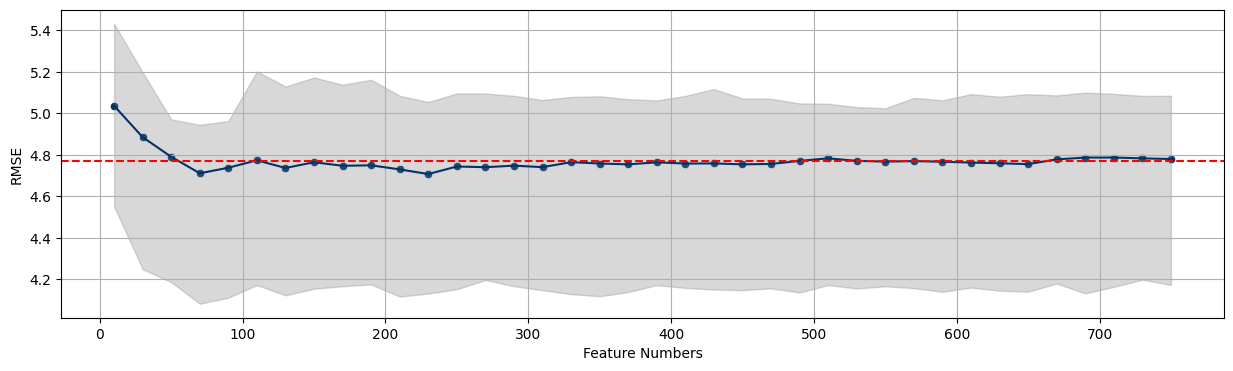

In [18]:
geral_feature_score = pd.DataFrame(feature_score, index=['RMSE', '1Q', '3Q']).T

plt.figure(figsize=(15, 4))
sns.scatterplot(x=geral_feature_score.index, y=geral_feature_score['RMSE'])
sns.lineplot(x=geral_feature_score.index, y=geral_feature_score['RMSE'])
plt.fill_between(x=geral_feature_score.index, y1=geral_feature_score['1Q'], 
                 y2=geral_feature_score['3Q'], color='gray', alpha=0.3)

plt.axhline(y=threshold_rsme, color='red', linestyle='--')

plt.xlabel('Feature Numbers')
plt.grid()
plt.show()

The blue line represents the average RMSE, while the grey area represents the range between the first and third quartiles.

Above, we can see how the Random Forest model performed for each feature set relative to the threshold. The model did not fit well, indicating that even with hyperparameter tuning, it is unlikely to achieve performance that justifies its use.

### XGBoost

The XGBoost model structure differs from Random Forest, so it may produce different results. To allow comparison, we applied the same method used for Random Forest.

In [19]:
xgboost_feature_score = {}

for feature_set in tqdm(feature_collection):    
    kf = KFold(n_splits=10, shuffle=True, random_state=25)
    rmse_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx][feature_set], X.iloc[val_idx][feature_set]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
        model = XGBRegressor(
            objective="reg:squarederror",
            random_state=25
        )
        model.fit(X_train, y_train)
    
        # Predict & evaluate
        y_pred = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_scores.append(rmse)

    xgboost_feature_score[len(feature_set)] = [np.mean(rmse_scores), np.quantile(rmse_scores, 0.25), np.quantile(rmse_scores, 0.75)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [06:00<00:00,  9.49s/it]


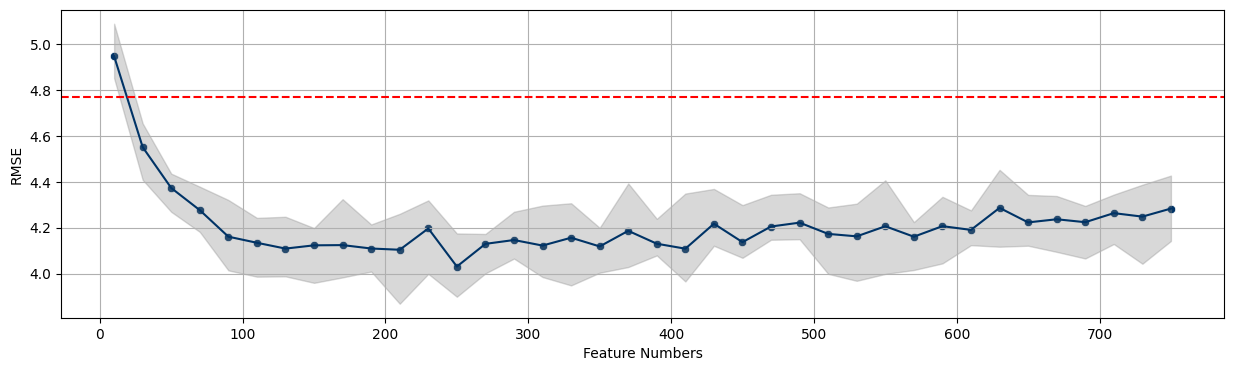

In [20]:
geral_xgboost_feature_score = pd.DataFrame(xgboost_feature_score, index=['RMSE', '1Q', '3Q']).T

plt.figure(figsize=(15, 4))
sns.scatterplot(x=geral_xgboost_feature_score.index, y=geral_xgboost_feature_score['RMSE'])
sns.lineplot(x=geral_xgboost_feature_score.index, y=geral_xgboost_feature_score['RMSE'])
plt.fill_between(x=geral_xgboost_feature_score.index, y1=geral_xgboost_feature_score['1Q'], 
                 y2=geral_xgboost_feature_score['3Q'], color='gray', alpha=0.3)

plt.axhline(y=threshold_rsme, color='red', linestyle='--')

plt.xlabel('Feature Numbers')
plt.grid()
plt.show()

Here, we can clearly see that XGBoost outperformed Random Forest. Based on this, XGBoost was chosen as the model. The features were initially selected based on Random Forest performance; however, given the large performance gap between XGBoost and Random Forest, it is possible that the selected features are not optimal for XGBoost. Therefore, we will re-define the feature relevance order.


## XGBoost SHAP
Let’s begin the new feature selection using the SHAP method. Below, we can see all the possible features.

In [21]:
feature_eng = pd.read_parquet(DATA_PATH_WRANGLE / 'possible_features.parquet')
feature_eng.head()

,tavg_365,tavg_366,tavg_367,tavg_368,tavg_369,tavg_370,tavg_371,tavg_372,tavg_373,tavg_374,...,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,season_Autumn,season_Spring,season_Summer,resid
time,,,,,,,,,,,,,,,,,,,,,
2017-09-01,294.1,296.3,299.0,299.1,298.5,298.1,296.5,298.2,298.4,296.6,...,False,False,False,False,False,True,True,False,False,-5.196970
2017-09-02,294.2,294.1,296.3,299.0,299.1,298.5,298.1,296.5,298.2,298.4,...,False,False,False,False,False,True,True,False,False,-5.567526
2017-09-03,294.3,294.2,294.1,296.3,299.0,299.1,298.5,298.1,296.5,298.2,...,False,False,False,False,False,True,True,False,False,-1.734199
2017-09-04,295.8,294.3,294.2,294.1,296.3,299.0,299.1,298.5,298.1,296.5,...,False,False,False,False,False,True,True,False,False,0.003016
2017-09-05,299.3,295.8,294.3,294.2,294.1,296.3,299.0,299.1,298.5,298.1,...,False,False,False,False,False,True,True,False,False,-5.655879


For the SHAP method, we first need to train the XGBoost model using all available features.

In [22]:
X_train, X_val, y_train, y_val = train_test_split(feature_eng.drop(columns=['resid']), feature_eng[['resid']], 
                                                  test_size=0.33, random_state=25)

# Train model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


With the model trained, we can measure the relevance of each feature. Based on this ranking, we select the top 100 features. In the next step, we will test combinations of these 100 features to determine which set achieves the best performance.

In [25]:
# Create the explainer
explainer = shap.TreeExplainer(xgb)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_val)

# Calculate Metric
mean_shap = np.abs(shap_values).mean(axis=0)
feature_importance = dict(zip(X_val.columns, mean_shap))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Top 70 features
top_features = [f for f, v in sorted_features[:70]]

With this list, we can proceed to the next step: testing each feature combination to identify the optimal set, after which we will move on to hyperparameter tuning.

In [26]:
with open(os.path.join(DATA_PATH_WRANGLE, "top_100_features.pkl"), "wb") as f:
    pickle.dump(top_features, f)